In this notebook we show how to build a Convolutional Neural Network (CNN) with TensorFlow to classify time series. The task here is to classify 6 different types of activities (walking, walking upstairs, walking downstairs, sitting, standing, laying) based on x, y and z accelerometer signals. Instead of using 2D convolutional layer we build 1D convolutional layer (we set 2D convolution height to 1) to fit our 1D inputs. We build two 1D convolutional layers with Relu activation followed by a fully connected network with 2 layers. 

## Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
import matplotlib.pylab as plt
import plot_confusion_matrix as pcm
%matplotlib

Using matplotlib backend: MacOSX


## Loading data

 We first load the raw accelerometer signals (x, y and z axis). Each sample from the data set is a 2.56s window of an activity being performed recorded at a 50Hz rate which make 128 readings per sample, per axis.

In [2]:
os.chdir('data')
# Raw signals
# X axis
X_train_x_raw = np.loadtxt('X_x_train.txt')
X_test_x_raw = np.loadtxt('X_x_test.txt')
# Y axis
X_train_y_raw = np.loadtxt('X_y_train.txt')
X_test_y_raw = np.loadtxt('X_y_test.txt')
# Z axis
X_train_z_raw = np.loadtxt('X_z_train.txt')
X_test_z_raw = np.loadtxt('X_z_test.txt')

print("X_train_x_raw shape : {}".format(X_train_x_raw.shape))
print("X_test_x_raw shape : {}".format(X_test_x_raw.shape))
print("X_train_y_raw shape : {}".format(X_train_y_raw.shape))
print("X_test_y_raw shape : {}".format(X_test_y_raw.shape))
print("X_train_z_raw shape : {}".format(X_train_z_raw.shape))
print("X_test_z_raw shape : {}".format(X_test_z_raw.shape))

X_train_x_raw shape : (7352, 128)
X_test_x_raw shape : (2947, 128)
X_train_y_raw shape : (7352, 128)
X_test_y_raw shape : (2947, 128)
X_train_z_raw shape : (7352, 128)
X_test_z_raw shape : (2947, 128)


We normalize the signals (standard score normalization i.e. for each signal we substract its mean and divide it by its standard deviation).

In [3]:
def standard_score_normalization(x):
    x_m = np.mean(x, axis=1).reshape(-1,1)
    x_std = np.std(x, axis=1).reshape(-1,1)
    return (x - x_m)/x_std

In [4]:
# Scaling raw signals: Standard Score 
X_train_x_raw = standard_score_normalization(X_train_x_raw)
X_test_x_raw = standard_score_normalization(X_test_x_raw)

X_train_y_raw = standard_score_normalization(X_train_y_raw)
X_test_y_raw = standard_score_normalization(X_test_y_raw)

X_train_z_raw = standard_score_normalization(X_train_z_raw)
X_test_z_raw = standard_score_normalization(X_test_z_raw)

  Now we are going to build/reshape our training and test sets. We want each sample of the training/test set to have the following shape (number of samples, time serie height, time serie length, number of channels) with:
  - number of samples: the number of samples in the training or test set.
  - time serie height: the "height" just like the height of an image except that as we are considering 1D data, our "height" will be set to 1. 
  - time serie length: this corresponds to the number of readings in the time series, in our case 128.
  - number of channels: in image classification taks, this dimension would represent the 3 RGB levels of a pixel but in our case this will be the 3 dimensions of the accelerometer data: x, y and z.  

The function below reshapes the 3 raw signal arrays as we have explained:

In [5]:
def concatenate_xyz(x,y,z):
    data = np.empty((x.shape[0],1,x.shape[1],3))
    for i, rowx, rowy, rowz in zip(range(x.shape[0]),x,y,z):
        data[i,:,:,0] = rowx.reshape(1,-1)
        data[i,:,:,1] = rowy.reshape(1,-1)
        data[i,:,:,2] = rowz.reshape(1,-1)
    return data

In [6]:
X_train = concatenate_xyz(X_train_x_raw, X_train_y_raw, X_train_z_raw)
X_test = concatenate_xyz(X_test_x_raw, X_test_y_raw, X_test_z_raw)

print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))

X_train shape : (7352, 1, 128, 3)
X_test shape : (2947, 1, 128, 3)


We load the training and test sets labels and we convert them to 1 hot encoding.

In [7]:
y_train = np.loadtxt('y_train.txt') - 1
y_train = (np.arange(np.unique(y_train).shape[0]) == y_train[:, None]).astype(int)

y_test = np.loadtxt('y_test.txt') - 1
y_test = (np.arange(np.unique(y_test).shape[0]) == y_test[:, None]).astype(int)

print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']

y_train shape : (7352, 6)
y_test shape : (2947, 6)


## Helper functions

The functions below help us build the CNN :
  - We easily define weights and biases variables with the two first functions.
  - The third function helps us build convolutional layers with pooling and a relu activation.  
  - Finally, the last function builds fully connected layers with or without relu activation.

In [8]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.01))

def bias_variable(shape):
    return tf.Variable(tf.zeros(shape=shape))

def convolutional_layer(input,
                        input_channels, # number of input channels for the layer
                        filter_height, # will be set to 1 as we deal with 1D data
                        filter_width, # width of the filter
                        output_channels, # number of ouput channels for the layer
                        conv_stride=1, # convolution stride
                        pooling_size=1, # size of the pooling
                        pooling_stride=1): # stride of the pooling
    
    filter_weights = weight_variable([filter_height, filter_width, input_channels, output_channels])
    filter_biases = bias_variable([output_channels])
    # applying convolution to input
    conv_layer = tf.nn.conv2d(input, 
                              filter=filter_weights, 
                              strides=[1,1,conv_stride,1], 
                              padding = 'SAME')
    conv_layer += filter_biases
    # applying pooling to convolution layer
    conv_layer = tf.nn.max_pool(conv_layer,
                                ksize=[1,1,pooling_size,1], 
                                strides=[1,1,pooling_stride,1],
                                padding='SAME')
    # applying relu 
    conv_layer = tf.nn.relu(conv_layer)
    
    return conv_layer

def fully_connected_layer(input, num_input, num_output, relu=True):
    
    W = weight_variable(shape=[num_input, num_output])
    b = bias_variable(shape=[num_output])
    if relu:
        logit = tf.nn.relu(tf.matmul(input,W) + b)
    else:
        logit = tf.matmul(input,W) + b
        
    return logit, W, b

## Network and training parameters

We are going to build a CNN with two convolutional layers whose output will be fed into a 2 connected layer neural network. We first define the input shape as we explained previously (shape = (number of samples, time serie height, time serie length, number of channels), then we define the two convolutional layers structure (number of input channels, number of output channels, filter width... note that we do not define filter height as it is set to 1), the we define the number neurons in the hidden layer and finally we define the training parameters.

In [9]:
# input parameters
filter_height = X_train.shape[1] # = 1 as we deal with 1D data
ts_length = X_train.shape[2] # = 128 as mentionned before
input_channels = X_train.shape[3] # = 3 since we consider the 3 axis of the accelerometer data
num_labels = y_train.shape[1] # = 6, 6 different activities...

# 1st convolutional layer parameters
input_channels_1 = input_channels 
filter_width_1 = 30
output_channels_1 = 14

# 2nd convolutional layer parameters
input_channels_2 = output_channels_1
filter_width_2 = 15
output_channels_2 = 36

# Hiden layer parameters
num_hidden = 1000

# Training paramters
learning_rate = 1e-4
training_epoch = 100
batch_size = 10
display_step = 10
prob = 1. # dropout probability to keep a neuron
l = 1e-3# L2 regularization coefficient

## Building the graph

Now we define our graph inputs with the required shapes:

In [10]:
x = tf.placeholder(tf.float32, shape=[None, filter_height, ts_length, input_channels])
y = tf.placeholder(tf.float32, shape=[None, num_labels])

### Convolutional layers

We build the two convolutional layers. The convolutional stride is set to 1 for both of them. We set the pooling size to 10 and the corresponding stride to 2 which means we will take the max of 10 readings windows and slide the window of 2 readings.

In [11]:
conv_layer_1 = convolutional_layer(x, 
                                   input_channels_1, 
                                   filter_height,
                                   filter_width_1,
                                   output_channels_1,
                                   conv_stride=1,
                                   pooling_size=10,
                                   pooling_stride=2)

In [12]:
conv_layer_2 = convolutional_layer(conv_layer_1, 
                                   input_channels_2, 
                                   filter_height,
                                   filter_width_2,
                                   output_channels_2,
                                   conv_stride=1,
                                   pooling_size=10,
                                   pooling_stride=2)

### Connected layers

We build our connected layers. First we flatten the output of the convolutional layers to feed it into the connected network. The number of neurons in the first layer is equal to the size of this flattened array while the second layer size has been defined before. 

In [13]:
# We first flatten the output of the second convolutional layer to feed if in a 2-layer NN
shape = conv_layer_2.get_shape().as_list()
flatten_layer = tf.reshape(conv_layer_2, shape=[-1, shape[1] * shape[2] * shape[3]])

# 1 st fully connected layer
num_features = shape[1] * shape[2] * shape[3]
hidden_layer_1, W_1, b_1 = fully_connected_layer(flatten_layer, num_features, num_hidden)

# We add dropout to the first layer in order to control overfitting. We make it a placeholder so we can set it 
# to 0. when evaluating training cost and the network predictions.
keep_prob = tf.placeholder(tf.float32)
hidden_layer_1 = tf.nn.dropout(hidden_layer_1, keep_prob)

# 2nd fully connected layer. relu is set to False since we will apply softmax to this layer when 
# defining the cost in the next cell
hidden_layer_2, W_2, b_2  = fully_connected_layer(hidden_layer_1, num_hidden, num_labels, relu=False)

### Cost and optimization

In [14]:
# L2 regularization coefficient: we make it a placeholder so we can set it to zero when evaluating training cost
lam = tf.placeholder(tf.float32)
# cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hidden_layer_2, labels=y)+ 
                      lam * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2)))
# optimization
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
# network prediction
prediction = tf.argmax(tf.nn.softmax(hidden_layer_2), 1)

## Training

In [15]:
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)

print("Parameters:")
print("learning rate = {}".format(learning_rate))
print("training_epoch = {}".format(training_epoch))
print("batch_size = {}".format(batch_size))
print("drop out prob = {}".format(prob))
print("L2 regularization coeeficient = {}".format(l))
print("-- Conv layer 1 --")
print("input_channels_1 = {}".format(input_channels_1))
print("filter_width_1 = {}".format(filter_width_1))
print("output_channels_1 = {}".format(output_channels_1))
print("-- Conv layer 2 --")
print("input_channels_2 = {}".format(input_channels_2))
print("filter_width_2 = {}".format(filter_width_2))
print("output_channels_2 = {}".format(output_channels_2))
print("-- Hidden layer --")
print("hidden layer size = {}".format(num_hidden))
print("\n")

cost_log = []

for epoch in range(training_epoch):
    avg_cost = 0. 
    num_batch = X_train.shape[0] // batch_size
    
    # We first shuffle the training data
    shuffle = np.random.permutation(X_train.shape[0])
    X_train_s = X_train[shuffle, :, :, :]
    y_train_s = y_train[shuffle, :]
    
    for i in range(num_batch):
        batch_x = X_train_s[int(i*batch_size):int((i+1)*batch_size), :, :, :]
        batch_y = y_train_s[int(i*batch_size):int((i+1)*batch_size), :]
        train = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: prob, lam: l})
        c =  sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 1., lam: 0.})
        avg_cost += c/num_batch
                
    if epoch % display_step == 0:
        print("Epoch n° {:4d}. cost = {:.8f}".format(epoch, avg_cost))   
        
    cost_log.append(avg_cost)    

    
print("Training over...")
print("\n")

plt.figure(1)
plt.plot(range(len(cost_log)), cost_log)
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Training set cost")

y_train_pred = sess.run(prediction, feed_dict={x: X_train, keep_prob: 1.})
print('Training set report')
print(classification_report(np.argmax(y_train, axis=1), y_train_pred, target_names=label_names))


y_test_pred = sess.run(prediction, feed_dict={x: X_test, keep_prob: 1.})
print('Test set report')
print(classification_report(np.argmax(y_test, axis=1), y_test_pred, target_names=label_names))

plt.figure(2)
pcm.plot_confusion_matrix(confusion_matrix(np.argmax(y_train, axis=1), y_train_pred), label_names)
plt.figure(3)
pcm.plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1), y_test_pred), label_names)

plt.show()

Parameters:
learning rate = 0.0001
training_epoch = 100
batch_size = 10
drop out prob = 1.0
L2 regularization coeeficient = 0.001
-- Conv layer 1 --
input_channels_1 = 3
filter_width_1 = 30
output_channels_1 = 14
-- Conv layer 2 --
input_channels_2 = 14
filter_width_2 = 15
output_channels_2 = 36
-- Hidden layer --
hidden layer size = 1000


Epoch n°    0. cost = 1.02530215
Epoch n°   10. cost = 0.29057984
Epoch n°   20. cost = 0.22753637
Epoch n°   30. cost = 0.17279145
Epoch n°   40. cost = 0.12015282
Epoch n°   50. cost = 0.08120074
Epoch n°   60. cost = 0.04595017
Epoch n°   70. cost = 0.02868736
Epoch n°   80. cost = 0.02148027
Epoch n°   90. cost = 0.01136143
Training over...


Training set report
                    precision    recall  f1-score   support

           Walking       1.00      1.00      1.00      1226
  Walking upstairs       1.00      1.00      1.00      1073
Walking downstairs       1.00      1.00      1.00       986
           Sitting       1.00      1.00      1.

//anaconda/lib/python3.5/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


Training set cost per epoch

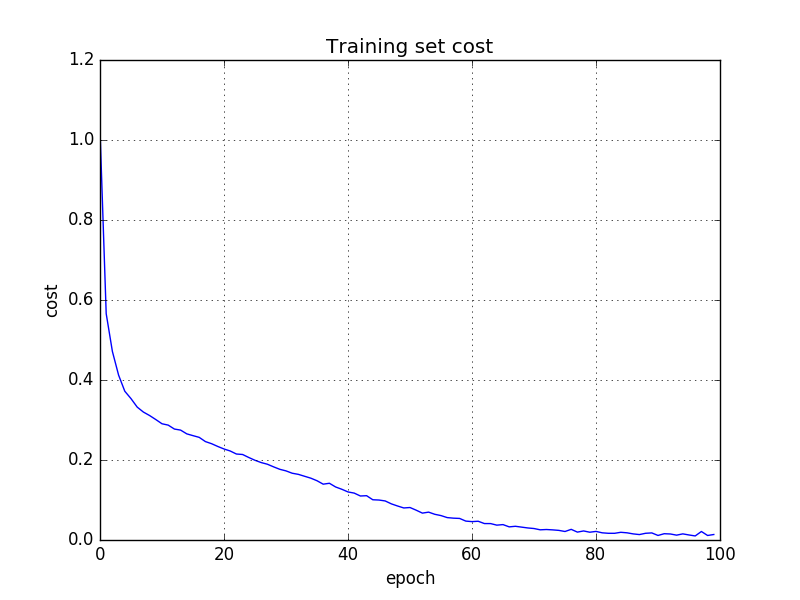

In [2]:
from IPython.display import Image
Image('images/cnn_c.png')

Confusion matrix: training set

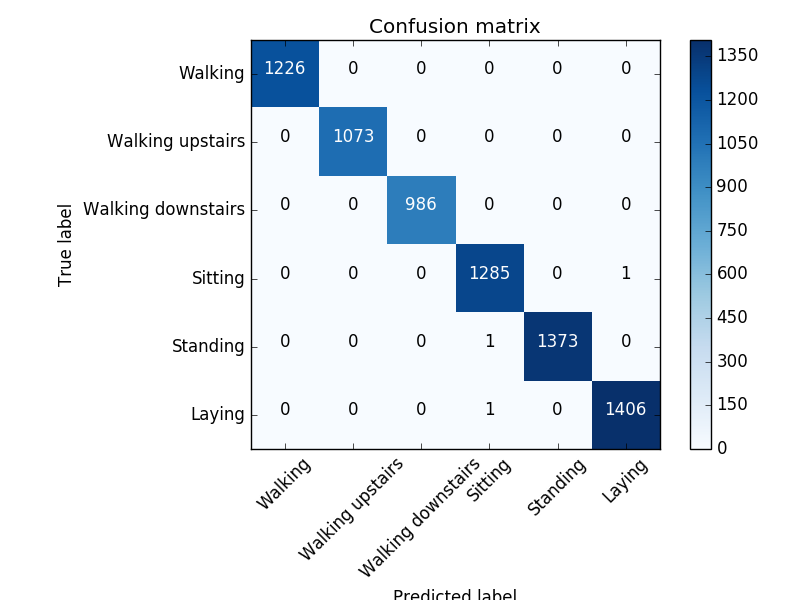

In [3]:
Image('images/cnn_train.png')

Confusion matrix: test set

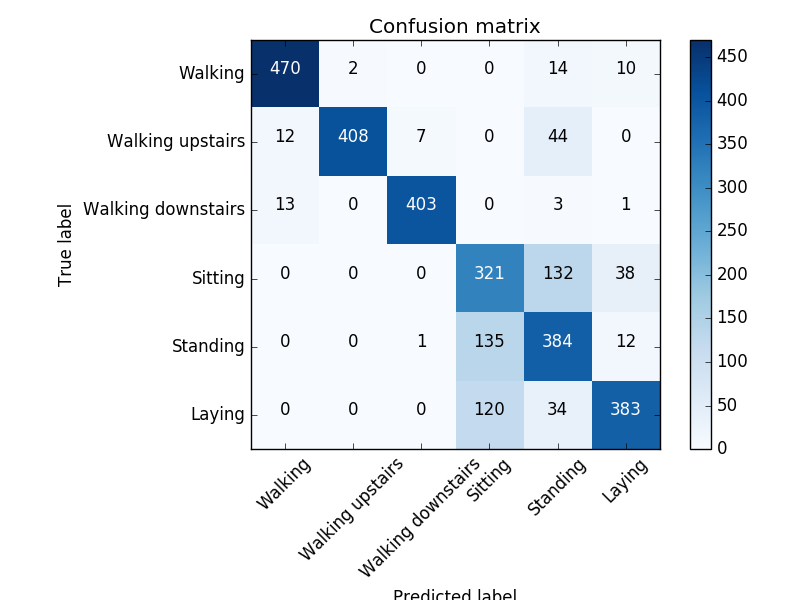

In [5]:
Image('images/cnn_test.png')

### Comments

Our 1D convolutional neural network makes quite good predictions using directly raw data. We obtain metrics on the test set similar to what we obtain in the notebook using feature data and SVM or neural network models (respectively [here](https://github.com/jeandeducla/ML-Time-Series/blob/master/SVM-Accelerometer.ipynb) and [here](https://github.com/jeandeducla/ML-Time-Series/blob/master/Neural_Network-Accelerometer-Features.ipynb)). The advantage of these thre methods is that we can feed our models with information on the three accelerometer axis. In the cas of this notebook, we can did that using the "channel" dimension of our input tensor.